# Import Libraries

In [0]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [6]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks
 abcnews-date-text.csv
 ab_data.csv
'A B Test.ipynb'
 AirPassengers.csv
'A method to categorical variable in flight delay datasets.ipynb'
'ARIMA Forecasting.ipynb'
 assignment0.ipynb
'assignment2_(release).ipynb'
 assignment2_sol.ipynb
 Automotive_5.json
'Building a Simple Chatbot.ipynb'
 chatbot.txt
'Classifying Tweets for Sentiment Analysis.ipynb'
'Community Detection.ipynb'
'Concrete Compressive Strength Pr

# Load Data

In [0]:
df = pd.read_excel('Online Retail.xlsx')

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


- InvoiceNo: Invoice number, a unique number assigned to each transaction.
- StockCode: Product/item code. a unique number assigned to each distinct product.
- Description: Product description
- Quantity: The quantities of each product per transaction.
- InvoiceDate: Invoice Date and time. The day and time when each transaction was generated.
- CustomerID: Customer number, a unique number assigned to each customer.

In [9]:
df.shape

(541909, 8)

# Check Missing Data

In [10]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [11]:
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [12]:
df.shape

(406829, 8)

# Data Preparation


In [0]:
df['StockCode']= df['StockCode'].astype(str)

In [14]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [0]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [16]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:04<00:00, 812.61it/s]


In [17]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1129.82it/s]


# Build word2vec Embeddings for Products

In [18]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3645764, 3682520)

In [0]:
# save word2vec model
model.save("word2vec_2.model")

In [0]:
model.init_sims(replace=True)

In [21]:
print(model)

Word2Vec(vocab=3179, size=100, alpha=0.03)


In [22]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3179, 100)

# Visualize word2vec Embeddings

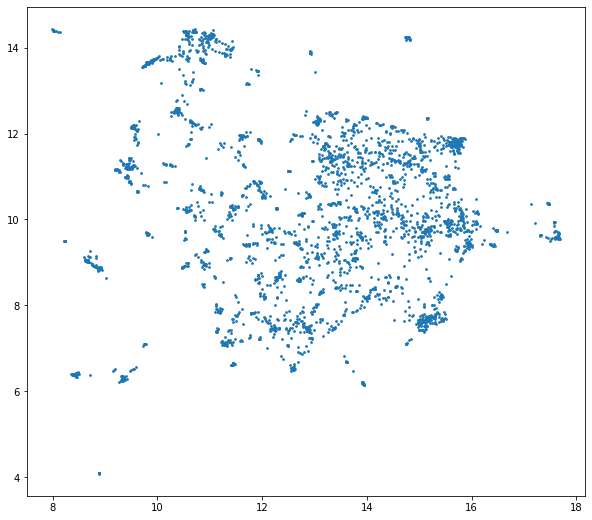

In [23]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')


# Product Remmendations

In [0]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [25]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

In [0]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms

In [27]:
similar_products(model['90019A'])

[('SILVER M.O.P ORBIT DROP EARRINGS', 0.7957180738449097),
 ('AMBER DROP EARRINGS W LONG BEADS', 0.7569602131843567),
 ('PINK HEART OF GLASS BRACELET', 0.7378568053245544),
 ('SILVER LARIAT BLACK STONE EARRINGS', 0.7340518832206726),
 ('PINK BOUDICCA LARGE BRACELET', 0.733978807926178),
 ('DROP DIAMANTE EARRINGS PURPLE', 0.7312412261962891)]

In [0]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [29]:
len(purchases_val[0])

196

In [30]:
aggregate_vectors(purchases_val[0]).shape

(100,)

In [31]:
similar_products(aggregate_vectors(purchases_val[0]))

[('JAM MAKING SET WITH JARS', 0.6852157115936279),
 ('SET OF 3 CAKE TINS PANTRY DESIGN ', 0.6827042102813721),
 ('PARTY BUNTING', 0.6795619130134583),
 ('SET OF 3 REGENCY CAKE TINS', 0.6687659025192261),
 ('SPOTTY BUNTING', 0.6669155359268188),
 ('SET OF TEA COFFEE SUGAR TINS PANTRY', 0.6611402630805969)]

In [32]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('SET OF 6 RIBBONS VINTAGE CHRISTMAS', 0.6516264081001282),
 ('SET OF 3 REGENCY CAKE TINS', 0.640785813331604),
 ("BISCUIT TIN 50'S CHRISTMAS", 0.6287319660186768),
 ("BOX OF 6 MINI 50'S CRACKERS", 0.6285550594329834),
 ("6 GIFT TAGS 50'S CHRISTMAS ", 0.620890736579895),
 ('PACK OF SIX LED TEA LIGHTS', 0.6186081171035767)]